In [1]:
DATAPATH = '../data/'
XFERPATH = '~/downloads/'  # To transfer files from Google Colab
FNAME = 'embeds_agg.csv'

In [2]:
frompath = XFERPATH + FNAME
topath = DATAPATH + FNAME
!cp $frompath $topath

In [3]:
import keras
import lightgbm as lgb
import pandas as pd
import gender_guesser.detector as gender
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from utils import get_rows, balance, balanced_split_by_time_and_id

/home/andy/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
df = pd.read_csv(DATAPATH+FNAME,index_col=[0,1],parse_dates=['time']).drop(['text'],axis=1)
df.head().iloc[:,:7]

,,name,male,embed0,embed1,embed2,embed3,embed4
id,time,,,,,,,
425472153,2019-05-25 20:24:48+00:00,Queen K,False,9156,-31075,-21194,41023,33810
1081873499621273601,2019-05-25 20:24:48+00:00,Alexandru Constantin,True,-34055,62140,-33476,1849,42774
987721418,2019-05-25 20:24:48+00:00,Susie Carmichael,False,-38618,12734,6150,6856,29976
980758839770451973,2019-05-25 20:24:52+00:00,Princess Sih.,False,-19252,-1482,-14205,-25178,-47939
838620336367218692,2019-05-25 20:24:53+00:00,Reid Kisselback,True,-40698,32644,3243,-35412,61766


In [5]:
print(df.shape)
df.index.get_level_values(1).min(), df.index.get_level_values(1).max()

(29678, 514)


(Timestamp('2019-05-21 17:50:48+0000', tz='UTC'),
 Timestamp('2019-05-26 12:53:53+0000', tz='UTC'))

In [6]:
xy_train, xy_valid, xy_test = balanced_split_by_time_and_id(df)

X_train = xy_train.drop(['name','male'],axis=1).dropna().values / 1e6
y_train = 1*xy_train.male.values

X_valid = xy_valid.drop(['name','male'],axis=1).dropna().values / 1e6
y_valid = 1*xy_valid.male.values

X_test = xy_test.drop(['name','male'],axis=1).dropna().values / 1e6
y_test = 1*xy_test.male.values

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [8]:
X_train.shape

(13320, 512)

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_dim=512))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dropout(.8))
model.add(keras.layers.Dense(8, activation='relu',))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                24624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 392       
__________

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train,
          epochs=14,
          batch_size=128,
          validation_data=[X_valid,y_valid])

Train on 13320 samples, validate on 4326 samples
Epoch 1/14
13320/13320 [==============================] - 1s 92us/step - loss: 0.7092 - acc: 0.5161 - val_loss: 0.6857 - val_acc: 0.5021
Epoch 2/14
13320/13320 [==============================] - 0s 32us/step - loss: 0.6848 - acc: 0.5520 - val_loss: 0.6750 - val_acc: 0.5911
Epoch 3/14
13320/13320 [==============================] - 0s 33us/step - loss: 0.6775 - acc: 0.5682 - val_loss: 0.6730 - val_acc: 0.5869
Epoch 4/14
13320/13320 [==============================] - 0s 35us/step - loss: 0.6721 - acc: 0.5800 - val_loss: 0.6726 - val_acc: 0.6001
Epoch 5/14
13320/13320 [==============================] - 0s 34us/step - loss: 0.6685 - acc: 0.5831 - val_loss: 0.6646 - val_acc: 0.6019
Epoch 6/14
13320/13320 [==============================] - 0s 35us/step - loss: 0.6657 - acc: 0.5971 - val_loss: 0.6652 - val_acc: 0.6112
Epoch 7/14
13320/13320 [==============================] - 0s 34us/step - loss: 0.6672 - acc: 0.5945 - val_loss: 0.6669 - val_acc:

In [11]:
y_train_pred = model.predict(X_train)
f1_score(y_train, y_train_pred>.5)

0.5897605284888521

In [12]:
y_pred = model.predict(X_valid)
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[1536  627]
 [1044 1119]]


0.5725249424405219

In [13]:
y_test_pred = model.predict(X_test)
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[1499  582]
 [1061 1020]]


0.5538962802063535

In [14]:
accuracy_score(y_test, y_test_pred>.5)

0.6052378664103796

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

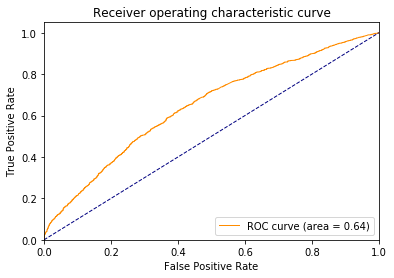

In [16]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()